In [1]:
# 행위자 - 비평자 모형

# 제 3장에서 배운 "심층 Q 신경망"은 이산적인 동작 공간(up,down,left,right)에선 상당히 효율적이다.
# 또한 학습속도가 무척 빨라 학습에 필요한 시간이 적었다.
# 하지만 정책 자체를 직접 다루는 것이 아니고,
# 기대보상(Value)을 학습하기 때문에 엡실론 탐욕과 같은 개별적인 정책이 필요하다는 단점을 가졌다.

# 이러한 단점을 개선하기 위해 정책기울기, 그 중 한가지 방법인 제 4장의 "REINFORCE" 알고리즘(PG)이 나왔다.
# REINFORCE 의 장점은 확률분포를 최적화하는 방향으로 학습하기에 연속적인 동작 공간(0~100km/h)을 적용할 수 있으며,
# 정책 자체를 학습하기 때문에 개별적인 정책이 필요하지 않는다는 점이다.

# 쉽게 말하면,
# Q learning 은 "이 상태에선 1번 행동을 하는게 더 좋아!" 라고 직접 가르쳐주는 것이고,
# Policy Gradient 는 "이 상태에선 2번 선택을 하는게 확률적으로 더 좋아!"
# 또는 "이 차도에선 시속 75km/h 로 달리는게 확률적으로 가장 높아!"
# 라고 가르쳐주는 것이다.

In [3]:
# 이번에 배울 건 Q-learning 과 REINFORCE 를 병합한
# Actor-Critic Algorithm (DA2C) 에 대해서 배울 것이다.

# DA2C 는 Q 신경망처럼 온라인 학습(한턴 한턴 갱신)의 장점을 가지되,
# 경험재현이 필요하지 않다. (즉 파국적 망각을 방지하는 기능을 가짐)
# 또한 동작들의 확률분포(정책)에서 직접 동작을 선택하는 "정책기울기 방법"의 장점을 지녔다.

# Q 학습의 학습 - 하나의 환경에서 정보(보상)을 직접 배운다.
# 정책 기울기의 학습 - 긍정적인 보상을 긍정적으로 강화, 부정적인 보상을 부정적으로 강화 -> 강화의 개념에 더 잘 부합한다.

# 정책망을 개선하기 위해선 "갱신 빈도를 높여 표본 효율성을 개선"해야 하고, 
# "모형의 매개변수 갱신에 사용할 보상들의 분산을 줄여야 한다"

# 여기서 "갱신빈도를 높이기 위한 방법"으로는 N-단계 학습이 이루어지고,
# 보상들의 분산을 줄이기 위해선 행위자(정책망)을 견제하는 비평자(critic)을 두는 것이다.
# 여기서 행위자는 정책망, 즉 PG의 신경망이고,
# 비평자는 가치신경망, 즉 Q-learning 의 신경망이다.

# 즉 DA2C는 정책망과 가치신경망이 공존하는 알고리즘이다.


In [13]:
# DA2C를 사용하기 위해선 우선 다중프로세스를 다룰 줄 알아야 하기에
# 다중 프로세스(여러 CPU를 동시에 다루는 것)를 먼저 공부하도록 하겠다.

# 다중 프로세싱 예제

import multiprocessing as mp
import numpy as np

# 각각의 CPU가 행할 작업을 정의한다.
def square(x):
  return np.square(x)

# 0~63 까지의 array 를 생성한다.
x = np.arange(64)

In [14]:
# 다룰 수 있는 cpu 갯수를 확인할 수 있다.
mp.cpu_count()

2

In [15]:
# 8개짜리 다중 프로세스 풀을 만든다. (CPU에 8명의 일꾼을 준비)
pool = mp.Pool(8)

# pool의 map 메소드를 사용해서 
# 8개의 다중 프로세스에 8개의 행렬을 각각 제곱시키도록 시킨다.
squared = pool.map(square, [x[8*i:8*i+8] for i in range(8)])
squared

[array([ 0,  1,  4,  9, 16, 25, 36, 49]),
 array([ 64,  81, 100, 121, 144, 169, 196, 225]),
 array([256, 289, 324, 361, 400, 441, 484, 529]),
 array([576, 625, 676, 729, 784, 841, 900, 961]),
 array([1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521]),
 array([1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209]),
 array([2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025]),
 array([3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969])]

In [18]:
# 개별 프로세스를 명시적으로 시작하는 예시

# 각 프로세스가 행할 작업을 명시
# 어떤 쓰레드가 해당 작업을 진행했는지 보여줌.
# (더욱 상세적임) 
def square(i, x, queue):
  print("In process {}".format(i,))
  queue.put(np.square(x))

####
# 기존
# def square(x):
#   return np.square(x)
####

# 각 프로세스 객체들의 주소들을 담을 리스트를 만든다.
processes = []
# 실행준비가 될 작업들을 담아놀 공간을 마련한다.
queue = mp.Queue()

# 계산할 값들을 ndarray 에 담는다.
x = np.arange(64)

for i in range(8):
  start_index = 8*i
  # 각각의 프로세스에 일을 맡긴다.
  proc = mp.Process(target=square, args=(i, x[start_index:start_index+8],queue))
  # 각각의 프로세스들을 실행준비 상태로 만든다.
  proc.start()
  # 그리고 프로세스 객체를 processes 리스트 안에 담아준다.
  processes.append(proc)

for proc in processes:
  # 각 프로세스들을 실행시키고 작업이 끝날때까지 기다린다.
  proc.join()

for proc in processes:
  proc.terminate()

results = []
while not queue.empty():
  results.append(queue.get())

results


In process 0
In process 2
In process 1
In process 3
In process 4
In process 5
In process 7
In process 6


[array([256, 289, 324, 361, 400, 441, 484, 529]),
 array([ 0,  1,  4,  9, 16, 25, 36, 49]),
 array([ 64,  81, 100, 121, 144, 169, 196, 225]),
 array([576, 625, 676, 729, 784, 841, 900, 961]),
 array([1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521]),
 array([1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209]),
 array([3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969]),
 array([2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025])]

In [20]:
# 개별 프로세스를 명시적으로 시작하는 예시

# 각 프로세스가 행할 작업을 명시
def square(i, x, queue):
  print("In process {}".format(i,))
  queue.put(np.square(x))

# 각 프로세스 객체의 주소들을 담을 리스트를 만든다.
processes = []
# 실행준비가 될 작업들을 담아놀 공간을 마련한다.
# multiprocess의 특별한 공유가능 자료구조, queue 를 이용해서
# 프로세스들이 데이터를 공유한다.
queue = mp.Queue()

# 계산할 값들을 ndarray 에 담는다.
x = np.arange(64)

for i in range(8):
  start_index = 8*i
  # 각각의 프로세스에 일을 맡긴다.
  proc = mp.Process(target=square, args=(i, x[start_index:start_index+8],queue))
  # 각각의 프로세스들을 실행준비 상태로 만든다.
  proc.start()
  # 그리고 프로세스 객체를 processes 리스트 안에 담아준다.
  processes.append(proc)

# for proc in processes:
#   # 각 프로세스들을 실행시키고 작업이 끝날때까지 기다린다.
#   proc.join()

for proc in processes:
  proc.terminate()

results = []
while not queue.empty():
  results.append(queue.get())

results

# proc.join() 이 없으면 앞에 있는 절차가 끝나면 뒤에 있는 것들을 무시하고 그냥 프로세스 모두 종료시킴.
# 반면에 proc.join() 을 해주면 모든 절차가 끝날 때 까지 기다려준다.


In process 0
In process 1
In process 2
In process 3
In process 4


[array([ 0,  1,  4,  9, 16, 25, 36, 49]),
 array([ 64,  81, 100, 121, 144, 169, 196, 225]),
 array([256, 289, 324, 361, 400, 441, 484, 529]),
 array([576, 625, 676, 729, 784, 841, 900, 961]),
 array([1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521])]

In [21]:
# 온라인 이익 행위자-비평자 의사코드
# Actor-critic 의 온라인 학습버전 알고리즘 
'''
# 할인율을 0.9로 지정
gamma = 0.9

# 매 턴마다 학습이 진행된다.
for i in epochs:
  # 상태를 얻는다.
  state = environment.get_state()

  # 해당 상태의 가치를 비평신경망을 통해 얻어낸다.
  value = critic(state)

  # 해당 상태에서의 정책을 정책신경망을 통해 얻어낸다.
  policy = actor(state)
  
  # 행동을 정책신경망에서 가져온다.
  action = policy.sample()
  
  # 해당 행동을 진행해 다음 상태와 보상을 산출한다.
  next_state, reward = environment.take_action(action)
  
  # 다음 가치를 비평신경망을 통해 얻어낸다.
  value_next = critic(next_state)

  # 이익을 계산한다.
  advantage = reward + (gamme*value_next - value)

  # 정책의 기대확률을 비평이 적용된 이익에 곱해 거기에 음수를 붙여 손실함수로 지정하고
  # 이 값을 최소화 하는 방향으로 역전파를 한다. -> 해당 값이 최소화 되면 즉 actor-critic 의 보상이 높아지는 방향으로 매개변수가 갱신된다.
  loss = -1*policy.logprob(action)*advantage
  minimize(loss)

'''

'\n# 할인율을 0.9로 지정\ngamma = 0.9\n\n# 매 턴마다 학습이 진행된다.\nfor i in epochs:\n  # 상태를 얻는다.\n  state = environment.get_state()\n\n  # 해당 상태의 가치를 비평신경망을 통해 얻어낸다.\n  value = critic(state)\n\n  # 해당 상태에서의 정책을 정책신경망을 통해 얻어낸다.\n  policy = actor(state)\n  \n  # 행동을 정책신경망에서 가져온다.\n  action = policy.sample()\n  \n  # 해당 행동을 진행해 다음 상태와 보상을 산출한다.\n  next_state, reward = environment.take_action(action)\n  \n  # 다음 가치를 비평신경망을 통해 얻어낸다.\n  value_next = critic(next_state)\n\n  # 이익을 계산한다.\n  advantage = reward + (gamme*value_next - value)\n\n  # 정책의 기대확률을 비평이 적용된 이익에 곱해 거기에 음수를 붙여 손실함수로 지정하고\n  # 이 값을 최소화 하는 방향으로 역전파를 한다. -> 해당 값이 최소화 되면 즉 actor-critic 의 보상이 높아지는 방향으로 매개변수가 갱신된다.\n  loss = -1*policy.logprob(action)*advantage\n  minimize(loss)\n\n'

In [22]:
# N-단계 학습

# N 단계 학습은 "매 턴마다 학습을 진행"하는 "온라인 학습"과,
# "매 에피소드(한 게임 모두 진행)마다 학습을 진행"하는 "몬테카를로 학습"의
# 중간 방식이다.

# 즉 한 에피소드가 진행되는 중에 몇번 갱신을 하는 작업이다.

In [25]:
# CartPole Actor-Critic Model

import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import torch.multiprocessing as mp

class ActorCritic(nn.Module):
  def __init__(self):
    # 생성자를 통해 필요한 층 객체들을 바로 생성한다.
    super(ActorCritic, self).__init__()
    self.l1 = nn.Linear(4,25)
    self.l2 = nn.Linear(25,50)
    self.actor_lin1 = nn.Linear(50,2)
    self.l3 = nn.Linear(50,25)
    self.critic_lin1 = nn.Linear(25,1)
  
  def forward(self,x):
    # 계산의 효율성 향상을 위해 정규화를 한다.
    x = F.normalize(x,dim=0)
    # l1층에서 나온 결과값들에 활성화함수(relu)를 적용시킨다.
    y = F.relu(self.l1(x))
    # l2층에서 나온 결과값들에 활성화함수(relu)를 적용시킨다.
    y = F.relu(self.l2(y))
    # 정책망 신경망의 결과값에 log_softmax 를 적용시켜 소프트맥스화 된 확률을 구해낸다.
    actor = F.log_softmax(self.actor_lin1(y))
    # l3의 결과값에 relu 를 적용한다.
    # 다만 비평신경망의 y값엔 역전파를 적용하지 않기에 y를 detach 한다.
    c = F.relu(self.l3(y.detach()))
    # l3층에서 나온 결과값을 비평신경망의 신경층에 넣어 기대가치를 뽑아낸다.
    # tanh 를 적용했기 때문에 -1 에서 1 사이의 값이 나온다.
    critic = torch.tanh(self.critic_lin1(c))
    # 정책망의 결과값과 비평망의 결과값을 출력한다.
    return actor, critic



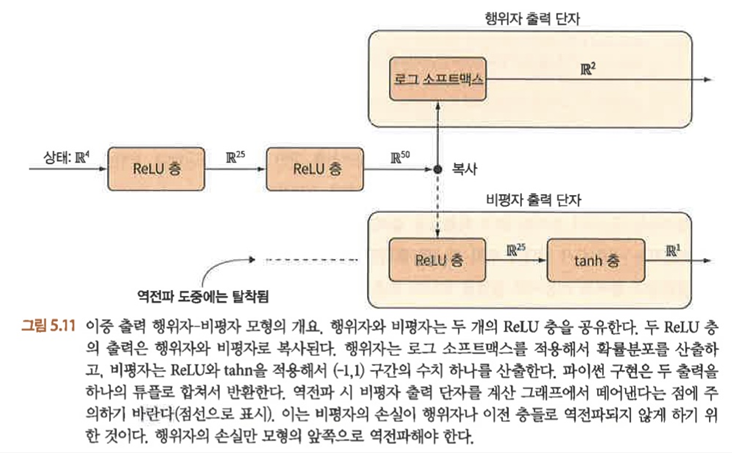

In [31]:
# 이제 훈련을 멀티프로세스로 실행시켜보자

# 훈련비평신경망 객체를 생성한다.
MasterNode = ActorCritic()

# share_memory 메서드는 프로세스들이 모형의 매개변수들을 각자 복사하는 것이 아니라,
# 그대로 공유하게 만든다. -> 즉 각 프로세스들의 매개변수가 동기화된다.
MasterNode.share_memory()

# 프로세스 객체들을 담을 공간을 초기화한다.
processes = []

# 에포크수는 1000으로, 동시에 쓸 쓰레드의 수는 7개로 지정한다.
params = {
    'epochs':1000,
    'n_workers':7
}

# 멀티프로세스의 내장 공유 객체를 하나의 전역 공유 카운터로 사용한다.
# 'i'는 이 공유 객체의 데이터 형식이 정수(integer)라는 뜻이다.
counter = mp.Value('i',0)
# 즉 i가 각각의 프로세스의 ID가 되어 하나하나를 명시적으로 지정할 수 있다.

# 프로세스의 갯수만큼 포문을 돌린다.
for i in range(params['n_workers']):
  # 각각의 프로세스에 해당 params 를 가진 worker 라는 신경망을 탑재한다.
  p = mp.Process(target=worker, args=(i, MasterNode, counter, params))

  # 각 프로세스를 실행준비 및 실행시킨다.
  p.start()
  # 실행중인 프로세스 리스트에 추가한다.
  processes.append(p)

for p in processes:
  # 모든 프로세스들이 끝날때까지 기다린다.
  p.join()

for p in processes:
  # 다 끝나면 종료한다.
  p.terminate()

Process Process-81:
Process Process-82:
Process Process-83:
Process Process-84:
Traceback (most recent call last):
Process Process-85:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/l

In [30]:
# 주 훈련 루프 (worker)

# 여기서 worker_model 은 정책-비평 신경망이다.
def worker(t, worker_model, counter, params):
  # 게임환경을 불러온다.
  worker_env = gym.make("CartPole-v1")
  # 게임환경을 초기화한다.
  worker_env.reset()
  # 최적화기로는 Adam을 사용한다.
  # 그리고 갱신할 매개변수로는 worker_model, 즉 신경망으로 지정한다.
  worker_opt = optim.Adam(lr=1e-4, params=worker_model.parameters())
  # 매개변수를 초기화한다.
  worker_opt.zero_grad()
  for i in range(params['epochs']):
    # 매 에포크마다 최적화기의 값을 초기화한다.
    worker_opt.zero_grad()
    # 가치들, 정책값들, 보상을 한 episode 를 돌릴때마다 산출한다.
    values, logprobs, rewards = run_episode(worker_env, worker_model)
    # 가져온 가치값과 정책값, 그리고 보상을 Adam 최적화기에 넣어 손실함수를 구한다.
    actor_loss, critic_loss, eplen = update_params(worker_opt, values, logprobs, rewards)
    # 카운터에 1을 추가한다.(여기서 counter 는 모든 프로세스가 공유하는 전역 카운터이다.)
    counter.value = counter.value+1

# 각 프로세스는 각자 환경에서 worker 함수를 실행한다.
# worker 을 실행하는 각각의 일꾼 프로세스는 개별적인 CartPole 환경과,
# 개별적인 최적화기를 사용하지만, 둘째 인수로 주어진 행위자-비평자 모형(worker_model)을 공유한다.
# 즉, 모형이 공유되기 때문에 모든 일꾼 프로세스들은 같은 매개변수 집합을 갱신한다.

# 각 프로세스는 자신만의 주소 공간을 사용하기 때문에 모든 프로세스가 공유할 데이터(worker_model.parameters())는 반드시,
# 함수의 인수를 통해 명시적으로 전달해야만 한다.

In [32]:
# 에피소드 실행 코드

# 게임의 환경과 에이전트를 인수로 받는다.
def run_episode(worker_env, worker_model):
  state = torch.from_numpy(worker_env.env.state).float()
  values, logprobs, rewards = [],[],[]
  done = False
  j = 0

  # 게임이 끝나지 않는 한
  while(done==False):
    j+=1
    # 해당 환경에서의 정책망값과 기대가치값을 받아온다.
    policy, value = worker_model(state)
    # 기대가치값을 리스트에 담는다.
    values.append(value)
    
    # 정책 확률분포를 가져온다.
    logits = policy.view(-1)
    # 확률분포를 One-hot encoding 한다.[0.7 0.2 0.1] ->[1 0 0] 이렇게 바꿔주나?
    action_dist = torch.distributions.Categorical(logits=logits)
    # 확률분포에서 확률이 가장 높은 인덱스를 action에 담아준다.
    action = action_dist.sample()
    # 해당 행동의 로그확률값을 logprob_ 에 담아준다.
    logprob_ = policy.view(-1)[action]
    logprobs.append(logprob_)
    # 해당 행동을 하고 난 후의 상태값, 게임종료여부 를 state_, done 에 각각 담아준다.
    state_, _, done, info = worker_env.step(action.detach().numpy())
    # 새로운 상태를 토치행렬로 바꿔서 state에 담아준다.
    state = torch.from_numpy(state_).float()

    # 게임이 끝날 시
    if done:
      # 보상 -10을 받고, 게임 환경을 초기화한다.
      reward=-10
      worker_env.reset()

    else:
      # 게임이 끝나지 않았으면 보상 1을 받는다.
      reward = 1.0
      
    rewards.append(reward)
  
  return values, logprobs, rewards


In [2]:
# 신경망의 매개변수를 갱신하는 함수


def update_params(worker_opt, values, logprobs, rewards, clc=0.1, gamma=0.95):
  # 보상들을 역순해서 1차원 배열로 만든다.
  rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1)
  # 로그확률을 스택 자료구조로 담고 역순하고 1차원 배열로 만든다.
  logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
  # 기대가치들 또한 stack 자료구조로 담고 역순 후 1차원 배열로 만든다.
  values = torch.stack(values).flip(dims=(0,)).view(-1)
  # 보상들을 담을 리스트를 마련한다.
  Returns = []
  # 보상을 임시적으로 담을 ret_ 텐서공간을 초기화해준다.
  ret_ = torch.Tensor([0])
  # 보상의 갯수만큼 돌린다.
  for r in range(rewards.shape[0]):
    # 할인율을 고려한 보상을 계산한다.
    ret_ = rewards[r] + gamma*ret_
    # 보상에 할인율을 적용하였다.
    Returns.append(ret_)
  # 할인율이 고려된 보상들을 스택 자료구조에 넣어 1차원 구조로 만들어
  # Returns 변수에 대입한다.
  Returns = torch.stack(Returns).view(-1)
  # 그리고 Returns 스택 데이터를 Normalize(정규화)한다.
  Returns = F.normalize(Returns,dim=0)
  # 행위자의 손실로는 -1 * 로그확률 * (보상-기대가치) 로 적용해준다.
  # 즉 손실이 최소화가 되면 결국엔 보상이 최대화가 되는 방식이다.
  actor_loss = -1*logprobs*(Returns-values.detach())
  # 비평자의 경우 (기대가치-보상)의 제곱으로 손실함수를 정의해준다.
  critic_loss = torch.pow(values-Returns,2)
  # 그리고 총합 손실은 행위자의 손실합 + 0.1*비평자의 손실합 으로 해준다.
  # clc, 0.1 을 곱해주는 이유는 행위자가 더 빨리 배우도록 하기 위함이다.
  # 그만큼 비평가는 덜 빠르게 배워 뒤에서 견제해준다.
  loss = actor_loss.sum() + clc*critic_loss.sum()
  # 역전파를 한다. (오차를 히든층, 밀집층에 넘겨준다.)
  loss.backward()
  # 그리고 최적화기의 매개변수를 갱신한다. (step())
  worker_opt.step()
  # 행위자의 손실, 비평자의 손실, 그리고 len(rewards) 즉 지속시간, 보상을 리턴해준다.
  return actor_loss, critic_loss, len(rewards)


In [4]:
# 비평자는 최선의 수익을 산출하려는 반면에,
# 행위자는 비평자의 기대를 깨려고 한다.

# 비평자가 더 빠르게 개선되면 행위자의 손실이 커지고,
# 행위자가 빠르게 개선되면 반대로 비평자의 손실이 커진다.

# 즉 둘은 서로 견제한다.

# 행위자-비평자 모델은 비동기적으로 매개변수를 갱신한다.
# 예를 들어, 쓰레드 1이 CartPole 을 하는데,
# 30초째에 게임이 끝났다고 생각해보자.
# 반면에 쓰레드 2와 3은 40초, 60초 째 게임을 진행한다고 생각해보자.
# 쓰레드 1에서, 30초째 게임이 끝났기 때문에 학습이 진행되고,
# 신경망의 매개변수가 갱신된다.
# 그리고 갱신된 매개변수는 쓰레드 2와 3에 적용된다.
# 즉 쓰레드2, 3 입장에선 게임이 여전히 진행중인데 신경망이 발전을 하는 것이다.


# 하지만 이는 에피소드를 다 마친 후에 매개변수를 갱신하는 것이기에 아직은 "몬테카를로" 방식이다.
# 하지만 CartPole 이 아닌 더욱 복잡한 게임에선 매개변수들을 더 자주자주 갱신해줘야 한다.
# 그리고 이렇게 더 자주자주 갱신하는 방식을 N-단계 학습이라고 한다. (온라인과 몬테카를로의 중간)

# N-단계 학습은 중간중간에 신경망이 더 많이 발전하기 때문에
# 몬테카를로에 비해 현저히 적은 epochs 수에도 평균 보상이 올라간다.
# (몬테카를로는 2000 에포크수에 150이라는 점수에 다가가지만,
#  반면에 N-단계 학습은 120 에포크수에 150점에 도달한다.)



In [5]:
# CartPole N-단계 학습
def run_episode(worker_env, worker_model, N_steps = 10):
  # 현재 게임상황을 불러온다.
  raw_state = np.array(worker_env.env.state)
  # 게임상황을 토치행렬로 변경
  state = torch.from_numpy(raw_state).float()
  # 가치들과 로그확률, 그리고 보상들을 담을 리스트를 초기화한다.
  values, logprobs, rewards = [], [], []
  done = False
  # 게임이 몇 step 진행됬는지 확인할 j 변수를 만들어준다.
  j = 0
  # 게임이 끝나지 않았을 경우 진행되고 있던 상태의 기대보상을 담을 G 변수를 마련해준다.
  G = torch.Tensor([0])

  # j 가 N_steps 이상 진행되었거나, 또는 게임이 끝나면 while 문이 종료된다.
  while(j<N_steps and done==False):
    j+=1
    # 정책값과 가치값을 담아준다.
    policy, value = worker_model(state)
    # 기대가치 리스트에 넣어준다.
    values.append(value)
    # 확률분포를 1차원으로 만들어 logits 에 담아준다.
    logits = policy.view(-1)
    # 행동 분포를 Categorical 을 통해 원핫인코딩 해주고.
    action_dist = torch.distributions.Categorical(logits=logits)
    # 그중에서 최선의 선택의 인덱스를 뽑아준다.
    action = action_dist.sample()
    # 그리고 해당 선택 인덱스로 로그 확률을 뽑아낸다.
    logprob_ = policy.view(-1)[action]
    # 그리고 이를 logprobs 리스트에 넣어준다.
    logprobs.append(logprob_)
    # 행동을 게임에서 진행하고, 새로운 상태와 게임의 종료 여부를 받아낸다.
    state_,_,done,info = worker_env.step(action.detach().numpy())
    # 그리고 새로운 상태 또한 토치행렬로 변경해준다.
    state = torch.from_numpy(state_).float()
    # 만약 게임이 끝났으면
    if done:
      # 보상으로 -10을 넣어주고,
      reward = -10
      # 게임환경을 리셋한다.
      worker_env.reset()
    else:
      # 게임이 끝나지 않았으면 보상으로 1을 넣어주고,
      reward = 1.0
      # 현재까지 얻은 기대보상을 G에 담아준다. (다음 게임에 해당 점수를 넘겨주기 위함.)
      G = value.detach()
    rewards.append(reward)
  return values, logprobs, rewards, G

In [7]:
# N-단계 학습을 위한 update_params 함수
def update_params(worker_opt, values, logprobs, rewards, G, clc=0.1, gamma=0.95):
  rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1)
  logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
  values = torch.stack(values).flip(dims=(0,)).view(-1)
  Returns = []
  # ret_에 G가 들어가는 것만 다르다.
  # (기존 : # 보상을 임시적으로 담을 ret_ 텐서공간을 초기화해준다.)
  # ret_ = torch.Tensor([0])
  ret_ = G
  # 보상의 갯수만큼 돌린다.
  for r in range(rewards.shape[0]):
    # 할인율을 고려한 보상을 계산한다.
    ret_ = rewards[r] + gamma*ret_
    # 보상에 할인율을 적용하였다.
    Returns.append(ret_)
  # 할인율이 고려된 보상들을 스택 자료구조에 넣어 1차원 구조로 만들어
  # Returns 변수에 대입한다.
  Returns = torch.stack(Returns).view(-1)
  # 그리고 Returns 스택 데이터를 Normalize(정규화)한다.
  Returns = F.normalize(Returns,dim=0)
  # 행위자의 손실로는 -1 * 로그확률 * (보상-기대가치) 로 적용해준다.
  # 즉 손실이 최소화가 되면 결국엔 보상이 최대화가 되는 방식이다.
  actor_loss = -1*logprobs*(Returns-values.detach())
  # 비평자의 경우 (기대가치-보상)의 제곱으로 손실함수를 정의해준다.
  critic_loss = torch.pow(values-Returns,2)
  # 그리고 총합 손실은 행위자의 손실합 + 0.1*비평자의 손실합 으로 해준다.
  # clc, 0.1 을 곱해주는 이유는 행위자가 더 빨리 배우도록 하기 위함이다.
  # 그만큼 비평가는 덜 빠르게 배워 뒤에서 견제해준다.
  loss = actor_loss.sum() + clc*critic_loss.sum()
  # 역전파를 한다. (오차를 히든층, 밀집층에 넘겨준다.)
  loss.backward()
  # 그리고 최적화기의 매개변수를 갱신한다. (step())
  worker_opt.step()
  # 행위자의 손실, 비평자의 손실, 그리고 len(rewards) 즉 지속시간, 보상을 리턴해준다.
  return actor_loss, critic_loss, len(rewards)

In [8]:
# N-학습의 worker 함수
def worker(t, worker_model, counter, params):
  worker_env = gym.make("CartPole-v1")
  worker_env.reset()
  worker_opt = optim.Adam(lr=1e-4, params=worker_model.parameters())
  worker_opt.zero_grad()
  for i in range(params['epochs']):
    worker_opt.zero_grad()
    values,logprobs,rewards,G = run_episode(worker_env, worker_model)
    actor_loss, critic_loss, eplen = update_params(worker_opt, values, logprobs, rewards, G)
    counter.value = counter.value + 1

In [10]:
# 이렇게 N-학습을 진행하면 이전보다 더 나은 효과를 얻는다.
# 아래는 N-학습 결과이다.
# 우상향 하는 걸 볼 수가 있다. 중간중간 계속적으로 학습하기 때문

# 사람도 이와 똑같은 것 같다. 
# 사람도 중간중간 계속 의식하고 배우는게(갱신) 있으면 엄청난 속도로 빠르게 발전하곤 하는 것 같다.
# 새기자.

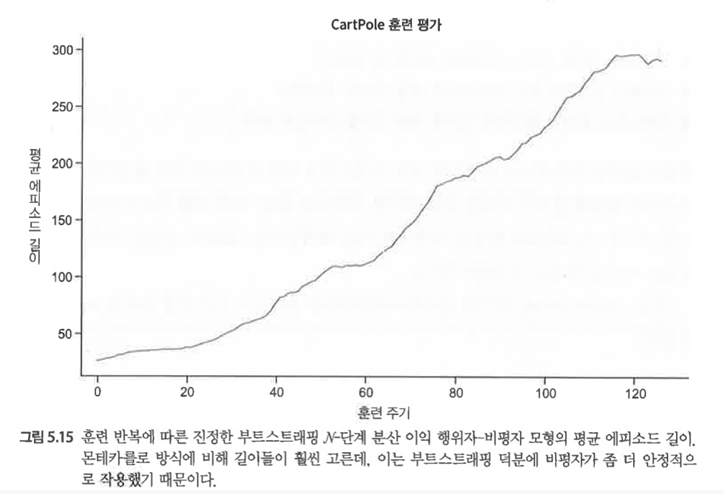